In [162]:
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pickle
from IPython.core.display import HTML
#import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import OrderedDict
from sklearn.externals import joblib #for saving model to disk
%matplotlib inline

<div class="span5 alert alert-info">
<h2>Notebook details</h2>

<p> This notebook is for <b>Logistic Regression</b> for <b>Kickstarter success prediction</b> project.</p>

<p> Notes.</p>
<ol>
<li>Perform baseline analysis </li>
<li>Perform feature important analysis </li>
<li>Perform multiple runs for training and test data to understand variation in accuracy </li>
<li> Apply logistic regression algorithm to the data
    <ul>
     <li>Extract Confusion matrix for logistic regression </li>
     <li>Extract classification report for logistic regression </li>
    </ul>
</li>        
</ol>
</div>

In [163]:
# setting some initial values and reading data from pickle file
pd.set_option('display.max_colwidth', -1)
color_success='#00ff66'#kickstarter green#'#2BDE73'
color_fail='#FF192F'#'#FFC7CE'#'#FFC7CE'#'#FF0000' # red
stateSuccess='Successful'
stateFail='Failed'
css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
cssAnalysis = '.analysis {background:#5bffc0; }' 
HTML('<style>{} {}</style>'.format(css,cssAnalysis))
pickle_file='DataStory_Jan2017_Jan2018.sa'
df_final_months = pickle.load( open( pickle_file, "rb" ) )
#df_final_months.info()
#df_final_months.head()

In [164]:
# filter out suspened, cancleed and live projects . converting staff from string to numeric value for models
df_fail_success_prior= df_final_months[(df_final_months.state==stateSuccess) | (df_final_months.state==stateFail)]
_=df_fail_success_prior.set_index('project_id')
df_fail_success=df_fail_success_prior.loc[:,['state','category','country','location_type','backers_count','staff_pick','usd_pledged','deadline_days']]
_=df_fail_success['staff_pick']= df_fail_success['staff_pick']*1
#df_fail_success.head()

## Helper methods

In [165]:
# Method to convert the category column into dummy columns 
def AddDummyColumnsToDataFrame(dfinput,colname,removelastdummy=False):
    print('Add {}'.format(colname))
    temp =pd.get_dummies(dfinput[colname])
    # remove one column from dummies with least value.
    if removelastdummy:
        t=dfinput.groupby(colname).count().state
        col_name=((t[t.values==t.min()]).index).get_values()[0]
        if col_name in temp.columns:
            print('removed column {}'.format(col_name))
            temp=temp.drop([col_name], axis=1)
    
    # remove the main column after extracting dummy
    if colname in dfinput.columns:
        print('removed column {}'.format(colname))
        dfinput =dfinput.drop([colname], axis=1)
    
    return  pd.concat([dfinput,temp], axis=1,ignore_index=False)

In [166]:
# Method for applying label encoding to column
def ModifyingColumnToLabel(df,colname):
    lab_enc = preprocessing.LabelEncoder()
    _=lab_enc.fit(df[colname])
    new_val = lab_enc.transform(df[colname])
    _=df.loc[:, '{}_val'.format(colname)] = new_val

In [167]:
# Method to extract Top N colums with strong infulence on success(1) and fail(0) for feature importance
def GetNFeaturesForImportance(cofficent,n=5):
    i=0
    column_cofficent = {}
    for element in np.nditer(cofficent):#featureimportance[0]:
        #for e in element:
        #print(('{0:.6f}').format(element))
        #print((element))
        column_cofficent[collist[i]]=float(element)
        i=i+1

    column_cofficent = [(k, column_cofficent[k]) for k in sorted(column_cofficent, key=column_cofficent.get, reverse=True)]
    #print(type(column_cofficent))
    positive_column_cofficent=column_cofficent[:n]
    negative_column_cofficent=column_cofficent[(-n):]
    positive_column_cofficent=pd.DataFrame(positive_column_cofficent)
    positive_column_cofficent=positive_column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    #positive_column_cofficent.set_index('feature',inplace=True)
    negative_column_cofficent=pd.DataFrame(negative_column_cofficent)
    negative_column_cofficent=negative_column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    #negative_column_cofficent.set_index('feature',inplace=True)
    column_cofficent=pd.DataFrame(column_cofficent)
    column_cofficent=column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    
    return(positive_column_cofficent,negative_column_cofficent,column_cofficent)

In [168]:
# Metjod to get classification report of train abd predict value for both train and predicted value of dependent(y)
def GetClassificationReport(yTrain, y_predict_training,ytestlr, y_predict_test, prefix=""):

    print(prefix + " [Training Classification Report:]"  )
    print('yTrain length= {}'.format( len(yTrain)))
    print('y_predict_training length= {}'.format( len(y_predict_training)))

    print(classification_report(yTrain, y_predict_training))

    print(prefix +"[Test Classification Report:]")
    print('ytestlr length= {}'.format( len(ytestlr)))
    print('y_predict_test length= {}'.format( len(y_predict_test)))
    
    print(classification_report(ytestlr, y_predict_test))

In [169]:
# Method to create confusion matrix for train and predicted value of dependent(y)
def GetConfusionMatrix(ytestlr, y_predict_test,prefix=""):
    print(prefix +"[GetConfusion Matrix Report:]")
    cm = confusion_matrix(ytestlr, y_predict_test)
    print(cm)

In [170]:
# Method to get the best estimator for model using GridSearch
def cv_optimize(clf, parameters, Xtrain, yTrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, yTrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [171]:
# Method to get split for test and train data
# indf : input data frame
#featurenames : csv list of all features applied to algo (X)
# targetname : target column name (Y)
#target1val : desired value for the target
# randomstate : random state parm for train_test_split
def provide_train_test_split_value(indf, featurenames, targetname,target1val,trainsize=0.8,randomstate=5):
    X=indf[featurenames].values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtestlr, yTrain, ytestlr = train_test_split(X, y, train_size=trainsize, random_state=randomstate)
    return Xtrain, yTrain, Xtestlr, ytestlr
    

In [172]:
# Method to apply ML algorithm based on parameters passed.
#clf : ML algo
#Xtrain, yTrain, Xtestlr, ytestlr : test and train data from split method
# parameters : hyper parameters for the findng best parameter
# standardize : Flag to get the model with standardize parameter of normal X
def do_classify(clf, parameters,Xtrain, yTrain, Xtestlr, ytestlr,standardize=False):
    #subdf=indf[featurenames]
    ##subdf[subdf.index.duplicated()]
    ##if standardize:
        ##print(featurenames)
    ##    subdfstd=(subdf - subdf.mean())/subdf.std()
    ##else:
     ##   subdfstd=subdf
    
    #subdfstd=subdf    
    #X=subdfstd.values
    #y=(indf[targetname].values==target1val)*1
    #Xtrain, Xtestlr, yTrain, ytestlr = train_test_split(X, y, train_size=train_size, random_state=5)
    
    clf = cv_optimize(clf, parameters, Xtrain, yTrain)
    if standardize:
        print('This is standard feature fit')
        clf=clf.fit(Xtrain / np.std(Xtrain, 0), yTrain) # with standardized parameters:
    else:
        print('This is normal fit')
        clf=clf.fit(Xtrain, yTrain) # without standardized parameters:
    
    training_accuracy = clf.score(Xtrain, yTrain)
    test_accuracy = clf.score(Xtestlr, ytestlr)
    
    # predict on training set
    y_predict_training = clf.predict(Xtrain)
    # predict on test set
    y_predict_test = clf.predict(Xtestlr)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
   
    return clf,y_predict_training,y_predict_test#, Xtrain, yTrain, Xtestlr, ytestlr

### Processing Starts

In [173]:
# Convert category columns to dummy columns
categoryColumns=['category','country','location_type']
for col in categoryColumns:
    print(col)
    df_fail_success=AddDummyColumnsToDataFrame(df_fail_success,col)

#df_fail_success.info()

category
Add category
removed column category
country
Add country
removed column country
location_type
Add location_type
removed column location_type


In [174]:
# remove columns not required before final processing . To confirm removal of any category column already converted to dummy and not required column 
for col_name in ['project_id','category','country','location_type','usd_goal']:
    if col_name in df_fail_success.columns:
            print('removed column {}'.format(col_name))
            df_fail_success=df_fail_success.drop([col_name], axis=1)

In [175]:
hyperparam =[0.01, 0.1, 1, 10, 100]
#hyperparam =[0.01, 0.015, 0.020, 0.025]

In [176]:
# The dummy coulmn have single quotes and spaces in name. The clean up for the column names 
#Rename columns by removing single quote(') and replace space with underscore(_) 
i=0
colnamelist=''
for col in df_fail_success.columns:
    i=i+1
    oldcolname=col
#if oldcolname.find(' ')>=0:
    newcolname=oldcolname.replace(' ','_').replace("'",'')
#if oldcolname.find("'")>=0:
    #newcolname=oldcolname.replace("'",'')
    if(oldcolname!=newcolname):
        df_fail_success = df_fail_success.rename(columns={oldcolname: newcolname})
        #print('new column name is ' + newcolname)
        #print('old column name is ' + oldcolname)
        
    if col !='state':
        #print(("'{}',").format(col))
        #colnamelist=colnamelist+("'{}',").format(col)
        colnamelist=colnamelist+('{},').format(newcolname)
        
print(i)
#print(colnamelist)

178


In [177]:
# create list of features 
collist =colnamelist.split(",")
collist.remove('')
len(collist)
#len(df_fail_success.columns)
#collist
#list(df_fail_success)
#collist

177

## Get traing and test split data common for all model

In [178]:
Xtrain, yTrain, Xtestlr, ytestlr  = provide_train_test_split_value(df_fail_success, collist, 'state',stateSuccess)

## Logistic Regression Implementation

<div class="span5 alert alert-info">
<h4>Running logistic regression and finding out classification report and confusion matrix </h4>
</div>

In [179]:
# logistic regression to find classification report and confusion matrix
# running the logistic regression without standardize parameters to find the model
# Confusion matrix and classification report is created on model

clf_l2, y_predict_training_l2, y_predict_test_l2= do_classify(LogisticRegression(),{"C": hyperparam},Xtrain, yTrain, Xtestlr, ytestlr,False)

# Creating classification report and confusion matrix for the traing and test data
GetClassificationReport(yTrain, y_predict_training_l2,ytestlr, y_predict_test_l2)
GetConfusionMatrix(ytestlr, y_predict_test_l2,"With l2(default)")


BEST PARAMS {'C': 0.01}
This is normal fit
Accuracy on training data: 0.82
Accuracy on test data:     0.83
 [Training Classification Report:]
yTrain length= 126194
y_predict_training length= 126194
             precision    recall  f1-score   support

          0       0.78      0.92      0.85     66280
          1       0.89      0.71      0.79     59914

avg / total       0.83      0.82      0.82    126194

[Test Classification Report:]
ytestlr length= 31549
y_predict_test length= 31549
             precision    recall  f1-score   support

          0       0.78      0.92      0.85     16616
          1       0.89      0.72      0.80     14933

avg / total       0.84      0.83      0.82     31549

With l2(default)[GetConfusion Matrix Report:]
[[15336  1280]
 [ 4236 10697]]


<div class="span5 alert alert-info">

<h4>Running logistic regression and feature importance analysis</h4>
</div>

In [180]:
# Run regression to find out important feature using standardize parameters
# the regression model with standardize parameter provides coffiecent which will be used to find the
# most important feature for success(1) and fail(0)

clf_l2_f, y_predict_training_l2_f, y_predict_test_l2_f= do_classify(LogisticRegression(),{"C": hyperparam},Xtrain, yTrain, Xtestlr, ytestlr,True)

# predict on training set
#y_predict_training_f_l2 = clf.predict(Xtrain)

# predict on test set
#y_predict_test_f_l2 = clf.predict(Xtestlr)
print("Feature importance coefficient of LogisticRegression")
cofficent_l2=clf_l2_f.coef_ 
print(cofficent_l2)

BEST PARAMS {'C': 0.01}
This is standard feature fit
Accuracy on training data: 0.60
Accuracy on test data:     0.59
Feature importance coefficient of LogisticRegression
[[  5.51873656e+00   3.58877223e-01   4.36929332e+00  -2.87341996e-01
   -6.03696925e-02  -4.89153938e-02  -7.32176958e-02  -7.88342632e-02
   -2.87551139e-02  -1.06841156e-01   1.78622673e-02  -1.53026126e-01
   -3.43432746e-01  -5.03045265e-02  -1.11059034e-02  -3.74436676e-02
   -3.22609833e-02   4.11589922e-03  -9.75958475e-03  -3.53164539e-02
   -6.60179179e-02  -9.01308191e-03  -5.89485612e-03  -5.73869237e-02
    1.86948723e-02  -2.53816797e-02   1.01283376e-01  -2.54433978e-02
    5.31885325e-02  -3.19381272e-02  -1.99690583e-02  -5.47443964e-02
    1.17755022e-01  -3.71674350e-02  -2.83723152e-02  -8.92569221e-02
   -1.47819731e-02  -5.24985235e-02   7.82678351e-01  -1.90076976e-02
   -1.10677142e-01  -2.95346773e-02  -2.96137645e-02  -6.96385991e-02
   -1.02596823e-02  -4.40295209e-02  -2.29501368e-03  -4.570

In [181]:
# find out top five (5) important feature
five_success_column_cofficent_l2,five_fail_column_cofficent_l2,column_cofficent_l2=GetNFeaturesForImportance(cofficent_l2)
success_column_cofficent_l2=column_cofficent_l2[column_cofficent_l2.Cofficent>0]
fail_column_cofficent_l2=column_cofficent_l2[column_cofficent_l2.Cofficent<=0]
print('Top 5 feature with towards success(1) : positive values')
print(five_success_column_cofficent_l2)

print('Top 5 feature with towards fail(0) : negative values')
print(five_fail_column_cofficent_l2)

Top 5 feature with towards success(1) : positive values
          feature  Cofficent
0  backers_count   5.518737 
1  usd_pledged     4.369293 
2  Shorts          0.845390 
3  Documentary     0.782678 
4  Tabletop_Games  0.700907 
Top 5 feature with towards fail(0) : negative values
         feature  Cofficent
0  Restaurants   -0.185053 
1  Software      -0.199256 
2  Web           -0.282043 
3  deadline_days -0.287342 
4  Apps          -0.343433 


<div class="span5 alert alert-info">
<h4>Top 5 feature with towards success(1) : positive values (l2)</h4>
    <ul>
     <li>backers_count : 5.518737 </li>
     <li> usd_pledged : 4.369293  </li>
     <li> Shorts       : 0.845390  </li>
     <li> Documentary  :  0.782678  </li>
     <li> Tabletop Games : 0.700907  </li>
    </ul>
    <br/>
<h4>Top 5 feature with towards fail(0) : negative values</h4>
    <ul>
     <li>Restaurants  : 0.185053   </li>
     <li> Software : 0.199256 </li>
     <li>  Web       : 0.282043   </li>
     <li> deadline_days :  0.287342   </li>
     <li> Apps : 0.343433  </li>
    </ul>    
</div>

#### Run LogisticRegression regularization parameter = l1

In [183]:
# logistic regression to find classification report and confusion matrix
# running the logistic regression without standardize parameters to find the model
# Confusion matrix and classification report is created on model
## penalty =l1

clf_l1, y_predict_training_l1, y_predict_test_l1= do_classify(LogisticRegression(penalty='l1'),{"C": hyperparam},Xtrain, yTrain, Xtestlr, ytestlr,False)
GetClassificationReport(yTrain, y_predict_training_l1,ytestlr, y_predict_test_l1)
GetConfusionMatrix(ytestlr, y_predict_test_l1,"With l1")


BEST PARAMS {'C': 100}
This is normal fit
Accuracy on training data: 0.78
Accuracy on test data:     0.78
 [Training Classification Report:]
yTrain length= 126194
y_predict_training length= 126194
             precision    recall  f1-score   support

          0       0.74      0.89      0.81     66280
          1       0.84      0.65      0.73     59914

avg / total       0.79      0.78      0.77    126194

[Test Classification Report:]
ytestlr length= 31549
y_predict_test length= 31549
             precision    recall  f1-score   support

          0       0.74      0.89      0.81     16616
          1       0.84      0.66      0.74     14933

avg / total       0.79      0.78      0.78     31549

With l1[GetConfusion Matrix Report:]
[[14811  1805]
 [ 5123  9810]]


<div class="span5 alert alert-info">

<h4>Running logistic regression and feature importance analysis (L1)</h4>
</div>

In [184]:
# Run regression to find out important feature using standardize parameters
# the regression model with standardize parameter provides coffiecent which will be used to find the
# most important feature for success(1) and fail(0)

##penalty='l1'
clf_f_l1, y_predict_training_f_l1, y_predict_test_f_l1= do_classify(LogisticRegression(penalty='l1'),{"C": hyperparam},Xtrain, yTrain, Xtestlr, ytestlr,True)

# predict on training set
#y_predict_training_f_l1 = clf.predict(Xtrain)

# predict on test set
#y_predict_test_f_l1 = clf.predict(Xtestlr)
print("Feature importance coefficient of LogisticRegression")
cofficent_l1=clf_f_l1.coef_ 
print(cofficent_l1)

BEST PARAMS {'C': 1}
This is standard feature fit
Accuracy on training data: 0.60
Accuracy on test data:     0.60
Feature importance coefficient of LogisticRegression
[[  2.68740165e+00   4.00940436e-01   3.27042366e+00  -1.82802862e-01
   -5.40706784e-02  -4.52347021e-02  -5.81782174e-02  -7.36151907e-02
   -2.53516046e-02  -9.96688760e-02   2.81296624e-02  -1.33474611e-01
   -3.29265411e-01  -4.50574426e-02   3.29815671e-03  -3.29510599e-02
   -2.85422553e-02   7.45319401e-03  -3.57619767e-03  -2.96710380e-02
   -6.32376005e-02  -4.86638263e-03   1.24863198e-02  -4.99107916e-02
    1.99920092e-02  -2.11946055e-02   1.12171760e-01  -1.25324958e-02
    6.60805998e-02  -3.06063307e-02  -1.47950221e-02  -4.74952814e-02
    1.36647264e-01  -3.50611728e-02  -2.70656508e-02  -8.32776682e-02
   -6.71534980e-03  -4.69754662e-02   6.07895455e-01  -1.05021982e-02
   -9.49593117e-02  -2.16882736e-02  -2.81168601e-02  -6.55502250e-02
   -4.88157783e-03  -4.28121360e-02   6.00639930e-03  -3.971606

In [185]:
# find out top five (5) important feature
five_success_column_cofficent_l1,five_fail_column_cofficent_l1,column_cofficent_l1=GetNFeaturesForImportance(cofficent_l1)
success_column_cofficent_l1=column_cofficent_l1[column_cofficent_l1.Cofficent>0]
fail_column_cofficent_l1=column_cofficent_l1[column_cofficent_l1.Cofficent<=0]
print('Top 5 feature with towards success(1) : positive values')
print(five_success_column_cofficent_l1)

print('Top 5 feature with towards fail(0) : negative values')
print(five_fail_column_cofficent_l1)

Top 5 feature with towards success(1) : positive values
          feature  Cofficent
0  usd_pledged     3.270424 
1  backers_count   2.687402 
2  Shorts          0.678813 
3  Documentary     0.607895 
4  Product_Design  0.527864 
Top 5 feature with towards fail(0) : negative values
         feature  Cofficent
0  Restaurants   -0.168901 
1  deadline_days -0.182803 
2  Software      -0.183272 
3  Web           -0.270048 
4  Apps          -0.329265 


<div class="span5 alert alert-info">
<h4>Top 5 feature with towards success(1) : positive values (l1)</h4>
    <ul>
     <li>backers_count : 3.270424  </li>
     <li> usd_pledged : 2.687402  </li>
     <li> Shorts       :  0.678813 </li>
     <li> Documentary  :  0.607895  </li>
     <li> Product_Design  : 0.527864 </li>
    </ul>
    <br/>
<h4>Top 5 feature with towards fail(0) : negative values</h4>
    <ul>
     <li>Restaurants  : 0.168901   </li>
     <li> deadline_days : 0.182803 </li>
     <li>  Software       : 0.183272   </li>
     <li> Web :  0.270048 </li>
     <li> Apps : 0.329265  </li>
    </ul>    
</div>

### Applying multiple trails to find out the variation in accuracy score.
### The training and test accuracy are very close. By running multiple splits will help to understand the difference between training and test split based on distinct runs.  

In [186]:
# Method to run the logistic regression with multiple value random state to provide diffeent test and train split each run
# Method also store the max and min value of test,train values and there related accuracy to get the accuracy score if required 
def MultipleSplitMethod(df,featurenames,targetname, targetval,parameters,n_splits=1000,train_size=0.8):
    training_accuracy = []
    test_accuracy = []
    accuracy_difference = []
    max_accuracy_yTrain= max_accuracy_y_predict_training=max_accuracy_ytestlr= max_accuracy_y_predict_test=max_accuracy_diff=0
    min_accuracy_yTrain= min_accuracy_y_predict_training=min_accuracy_ytestlr= min_accuracy_y_predict_test=min_accuracy_diff=0

    clf = LogisticRegression()

    # loop over multiple trials
    for i in range(0, n_splits):
        #print('npspli count {}'.format(i))
        # do split for this iteration, using shuffle and a different random_state 
        # for every iteration
        Xtrain, Xtestlr, yTrain, ytestlr = train_test_split(df[featurenames].values, 
                                                  (df[targetname] == targetval).values,random_state=i, train_size=train_size)
        # fit on the training set
        #clf.fit(Xtrain, yTrain) # updated this step gridsearch
        #clf = cv_optimize(clf, parameters, Xtrain, yTrain)
        clf=clf.fit(Xtrain, yTrain) # without standardized parameters:
        #clf=clf.fit(Xtrain / np.std(Xtrain, 0), yTrain) # with standardized parameters:

        # predict on training set
        y_predict_training = clf.predict(Xtrain)

        # predict on test set
        y_predict_test = clf.predict(Xtestlr)

        # save training accuracy for this split
        tr_accuracy = accuracy_score(y_predict_training, yTrain)
        training_accuracy.append(tr_accuracy)

        # save test accuracy for this split
        tst_accuracy = accuracy_score(y_predict_test, ytestlr)
        test_accuracy.append(tst_accuracy)

        # save difference
        accuracy_diff=tst_accuracy - tr_accuracy
        accuracy_difference.append(accuracy_diff)
        if accuracy_diff>max_accuracy_diff:
            #print("Min Accuracy values--> npspli :{} ,tr_accuracy : {}, tst_accuracy : {}, accuracy diff : {} ,  ytrain : {} ,  y_predict_training: {},  ytestlr: {},  y_predict_test: {} , "
            #      .format(i,tr_accuracy,tst_accuracy,accuracy_diff,yTrain,y_predict_training,ytestlr,y_predict_test))
            max_accuracy_diff=accuracy_diff
            max_accuracy_yTrain=yTrain
            max_accuracy_y_predict_training=y_predict_training
            max_accuracy_ytestlr=ytestlr
            max_accuracy_y_predict_test=y_predict_test
            #print("Correlation coefficient of LogisticRegression - max")
            #print(clf.coef_ )

        if accuracy_diff<min_accuracy_diff:
            #print("Min Accuracy values--> npspli :{} ,tr_accuracy : {}, tst_accuracy : {}, accuracy diff : {} ,  ytrain : {} ,  y_predict_training: {},  ytestlr: {},  y_predict_test: {} , "
            #     .format(i,tr_accuracy,tst_accuracy,accuracy_diff,yTrain,y_predict_training,ytestlr,y_predict_test))
            min_accuracy_diff=accuracy_diff
            min_accuracy_yTrain=yTrain
            min_accuracy_y_predict_training=y_predict_training
            min_accuracy_ytestlr=ytestlr
            min_accuracy_y_predict_test=y_predict_test
            #print("Correlation coefficient of LogisticRegression - min")
            #print(clf.coef_ )

    '''GetClassificationReport(min_accuracy_yTrain, min_accuracy_y_predict_training,min_accuracy_ytestlr, min_accuracy_y_predict_test,"Min")
    GetClassificationReport(max_accuracy_yTrain, max_accuracy_y_predict_training,max_accuracy_ytestlr, max_accuracy_y_predict_test,"Max")
    GetConfusionMatrix(min_accuracy_ytestlr, min_accuracy_y_predict_test,"Min")
    GetConfusionMatrix(max_accuracy_ytestlr, max_accuracy_y_predict_test,"Max")'''
    
    return  (training_accuracy,test_accuracy,accuracy_difference)

In [187]:
# Method to draw accuracy for both test and traing data to visualize
def DrawTrainingTestAccuracyplot(training_accuracy,test_accuracy):
    plt.figure(figsize=(12,8))
    training_plot, = plt.plot(training_accuracy, 'b',marker='o', linewidth=0)
    test_plot, = plt.plot(test_accuracy, 'r', alpha = 0.35,marker='o', linewidth=0)
    plt.legend([training_plot, test_plot], ['Training Accuracy', 'Test Accuracy'])
    plt.ylabel('Training vs Test Accuracy')
    plt.show()

In [188]:
# Method to draw only difference for test and traing data to visualize
def DrawTrainingTestAccuracyDifferenceplot(accuracy_difference):
    plt.figure(figsize=(12,8))
    diff_plot, = plt.plot(accuracy_difference, 'y',marker='o', linewidth=0)
    plt.legend([diff_plot], ['Difference'])
    plt.ylabel('Test/Training Difference Accuracy')
    plt.show()

### Running test with muliple splits( 1000)

In [ ]:
print(datetime.now())
training_accuracy,test_accuracy,accuracy_difference=MultipleSplitMethod(df_fail_success, collist, 'state',stateSuccess,{"C": hyperparam},1000)
print(datetime.now())

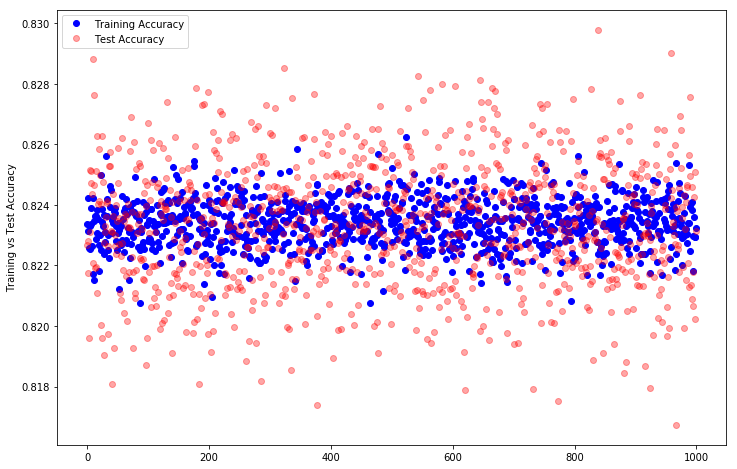

In [189]:
DrawTrainingTestAccuracyplot(training_accuracy,test_accuracy)

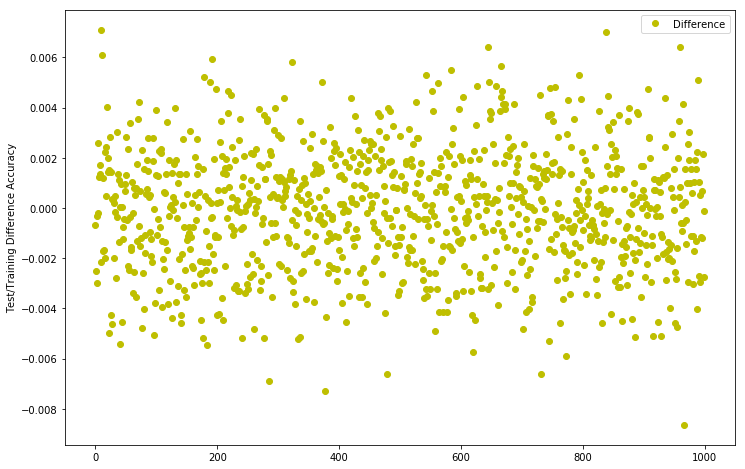

In [190]:
DrawTrainingTestAccuracyDifferenceplot(accuracy_difference)

<div class="span5 alert alert-info">
<h4>Traning VS Test Accuracy comparison</h4>
    <ul>
     <li> The distinct training accuracies are closer to each other as compared to test. This is obvious as a model is trained on that data.</li>
     <li> The maximum difference in test and training accuracy is 0.007. </li>
     <li> The above graphs and process are to get an idea about the difference in accuracy and is not final metrics. The classification report and confusion matrix provides more insight.</li>
   </ul>

</div>

### Box and Whisker plots for feature importance

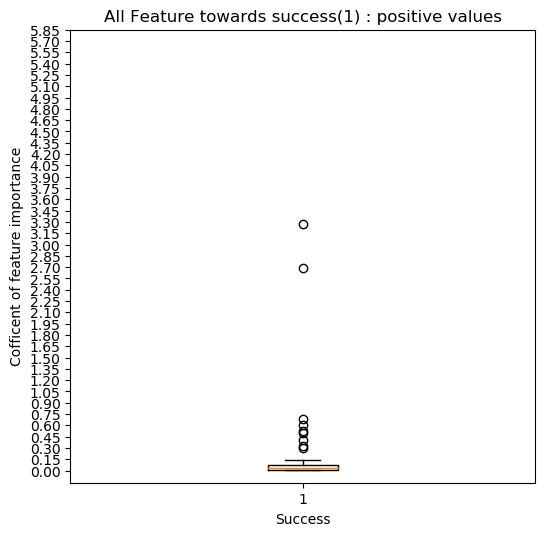

In [193]:
# Box and whsiker plot for all feature adding toward result of Success( 1)
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(success_column_cofficent_l1.Cofficent)

_=ax.set_yticks(np.arange(0,6,0.15))
_ =ax.set_xlabel('Success')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('All Feature towards success(1) : positive values')


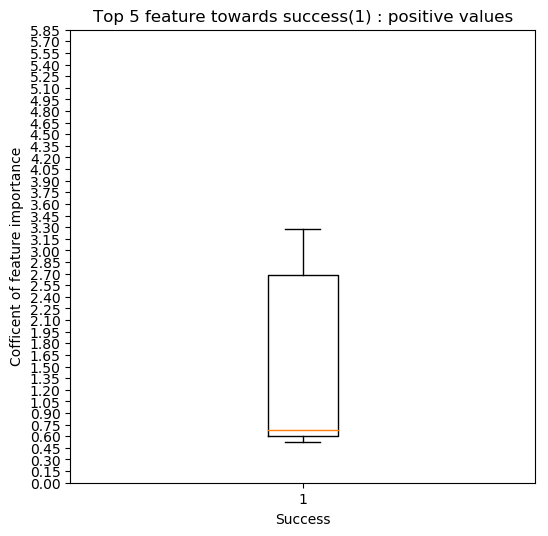

In [194]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(five_success_column_cofficent_l1.Cofficent)

_=ax.set_yticks(np.arange(0,6,0.15))
_ =ax.set_xlabel('Success')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('Top 5 feature towards success(1) : positive values')

<div class="span5 alert alert-info">
<h4>Top feature with towards success(1) : positive values</h4>
    <ul>
     <li>The spread of top positive feature is large due to top 2 value(5.55 & 4.50) being relatively very high numbers </li>
     <li> Most value resides in  lower range providing nearly same feature importance coefficient </li>
   </ul>

</div>

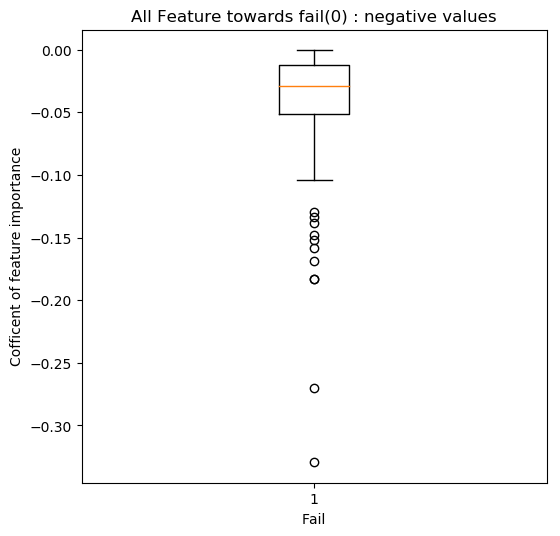

In [195]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
#_=ax.set_yticks(np.arange(0,6,0.15))
bp=ax.boxplot(fail_column_cofficent_l1['Cofficent'].values)
_ =ax.set_title('All Feature towards fail(0) : negative values')
#_=ax.set_yticks([0,6,0.0005])
_ =ax.set_xlabel('Fail')
_= ax.set_ylabel('Cofficent of feature importance')

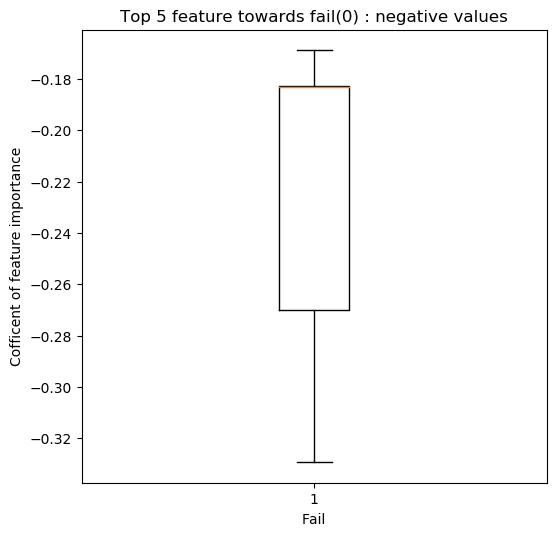

In [196]:
#ax=sns.boxplot(data=five_fail_column_cofficent, orient="h", palette="Set2")
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(five_fail_column_cofficent_l1.Cofficent)

#_=ax.set_yticks([0,6,0.0005])
_ =ax.set_xlabel('Fail')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('Top 5 feature towards fail(0) : negative values')

<div class="span5 alert alert-info">
<h4>Top feature with towards fail(0) : negative values</h4>
    <ul>
     <li>The spread of top negative feature is large due to top 2 value(0.35 & 0.30) being relatively very high numbers. </li>
     <li> Most value resides in higher(absolute number) range providing unlike success coefficient. </li>
     <li> The absolute value of fail is comparatively very small to success top most coefficient. </li>
   </ul>

</div>

### RandomForestClassifier

In [197]:
def FindNFeatureforRandomforestModel(featureimportances,N=5):
    #print(rftchoosen_feature_importances_1)
    five_success_column,five_fail_column,column_cofficent=GetNFeaturesForImportance(featureimportances,N)
    print(str.format('Top {} feature with towards success(1) : positive values',N))
    print(five_success_column_cofficent_rft_1)

    print(str.format('Top {} feature with towards fail(0) : negative values',N))
    print(five_fail_column_cofficent_rft_1)

In [198]:
# Method to apply ML algorithm based on parameters passed.
#clf : ML algo
#Xtrain, yTrain, Xtestlr, ytestlr : test and train data from split method
# maxfeature : Max_feature for random forest classifier
# randomstate : random_state for random forest classifier

RANDOM_STATE = 123
def do_radomforest(maxfeatures,estimator,Xtrain, yTrain, Xtestlr, ytestlr,randomstate=123):
    
    print(str.format('The random forest for max_feature ={} and n_estimator={} ',maxfeatures,estimator))
    rfc= RandomForestClassifier(max_features=maxfeatures, warm_start=True, oob_score=True,
                                n_estimators=estimator,random_state=randomstate)
    rfc.fit(Xtrain, yTrain)
    rfc_oob_error = 1 - rfc.oob_score_
    rfc_feature_importances=rfc.feature_importances_
    test_accuracy = rfc.score(Xtestlr, ytestlr)
    
    # predict on training set
    y_predict_training= rfc.predict(Xtrain)
    # predict on test set
    y_predict_test = rfc.predict(Xtestlr)
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print("oob error on model:     {:0.2f}".format(rfc_oob_error))
    GetClassificationReport(yTrain, y_predict_training_rftchoosen_1,ytestlr, y_predict_test_rftchoosen_1)
    GetConfusionMatrix(ytestlr, y_predict_test_rftchoosen_1,str.format("random forest ({})", estimator))
    FindNFeatureforRandomforestModel(rfc_feature_importances)
    return rfc,y_predict_training,y_predict_test

In [199]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
def PlotOOBerrGraph(errorrate,minestimators, maxestimators):
    min_key=-1
    min_val=-1
    fig, axis = plt.subplots(1,1,figsize=(12,12),dpi=100)
    print(str.format('Least OOB error value for estimators {}-{}',minestimators, maxestimators))
    for label, clf_err in errorrate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)
        min_val=min(ys)
        min_key=xs[ys.index(min_val) ]
        print(str.format('{},{},{}',min_val,min_key,label)) 

    
    plt.xlim(minestimators, maxestimators)
    plt.xlabel("n_estimators: ")
    plt.title(str.format('OOB error graph for estimators {}-{}',minestimators, maxestimators))
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

In [200]:
# Range of `n_estimators` values to explore. 15-175
min_estimators = 15
max_estimators = 175

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

for label, rfc in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        rfc.set_params(n_estimators=i)
        rfc.fit(Xtrain, yTrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - rfc.oob_score_
        error_rate[label].append((i, oob_error))

Least OOB error value for estimators 15-175
0.11446661489452747,169,RandomForestClassifier, max_features='sqrt'
0.11617826521070729,175,RandomForestClassifier, max_features='log2'
0.1192449720271962,173,RandomForestClassifier, max_features=None


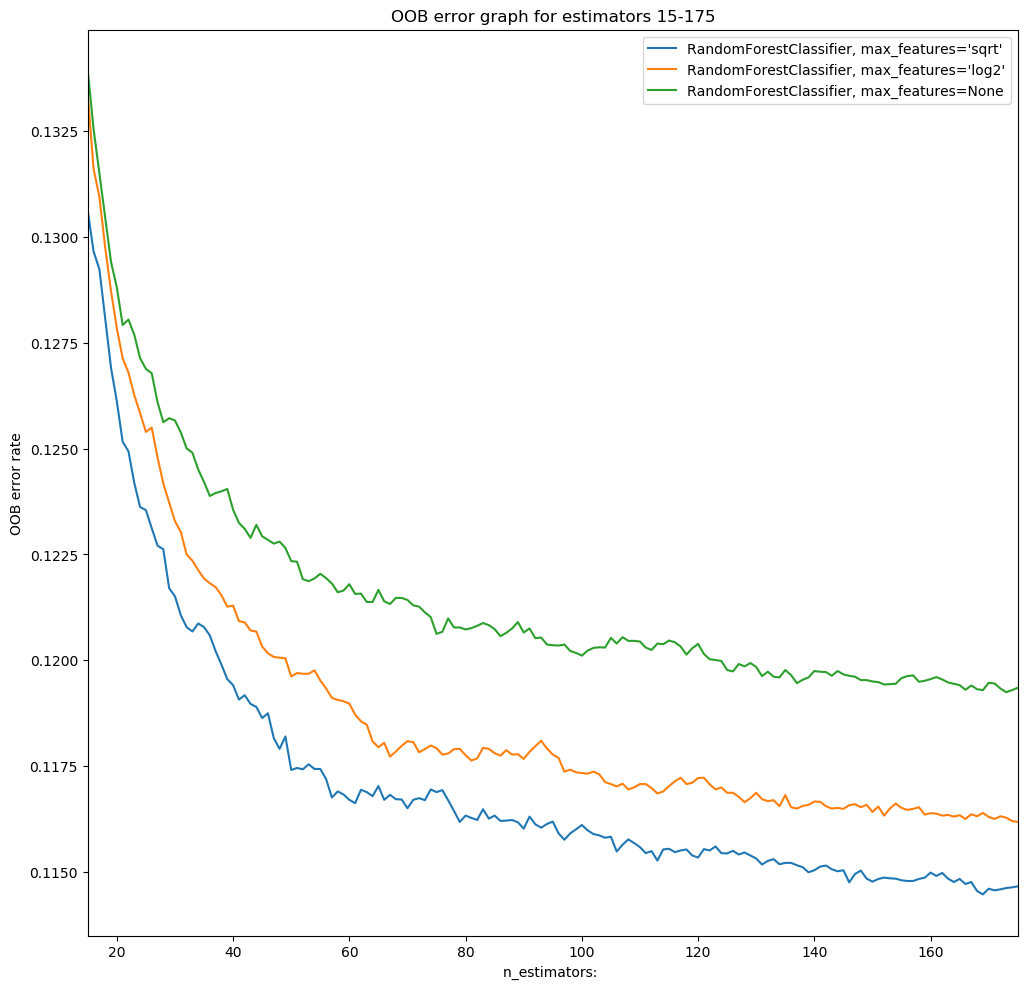

In [201]:
# create graph for all estimator and maxfeature
PlotOOBerrGraph(error_rate,min_estimators,max_estimators)

In [202]:
# create model for best estimator and feature based on lowest OOB error
rftchoosen,y_predict_training_rftchoosen,y_predict_test_rftchoosen=do_radomforest('sqrt',169,Xtrain, yTrain, Xtestlr, ytestlr)

The random forest for max_feature =sqrt and n_estimator=169 
Accuracy on test data:     0.89
oob error on model:     0.11
 [Training Classification Report:]
yTrain length= 126194
y_predict_training length= 126194
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     66280
          1       1.00      1.00      1.00     59914

avg / total       1.00      1.00      1.00    126194

[Test Classification Report:]
ytestlr length= 31549
y_predict_test length= 31549
             precision    recall  f1-score   support

          0       0.91      0.87      0.89     16616
          1       0.87      0.90      0.88     14933

avg / total       0.89      0.89      0.89     31549

random forest (169)[GetConfusion Matrix Report:]
[[14533  2083]
 [ 1498 13435]]
Top 5 feature with towards success(1) : positive values
         feature  Cofficent
0  usd_pledged    0.363263 
1  backers_count  0.342628 
2  deadline_days  0.058642 
3  staff_pick     0.029299 


In [203]:
# Range of `n_estimators` values to explore.
min_estimators_1 = 100
max_estimators_1 = 200
ensemble_clfs_1 = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate_1 = OrderedDict((label, []) for label, _ in ensemble_clfs_1)

for label, rfc in ensemble_clfs_1:
    for i in range(min_estimators_1, max_estimators_1 + 1):
        rfc.set_params(n_estimators=i)
        rfc.fit(Xtrain, yTrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error_1 = 1 - rfc.oob_score_
        error_rate_1[label].append((i, oob_error_1))

Least OOB error value for estimators 100-200
0.11418133984183088,199,RandomForestClassifier, max_features='sqrt'
0.11598808184224285,181,RandomForestClassifier, max_features='log2'
0.11910233450084795,200,RandomForestClassifier, max_features=None


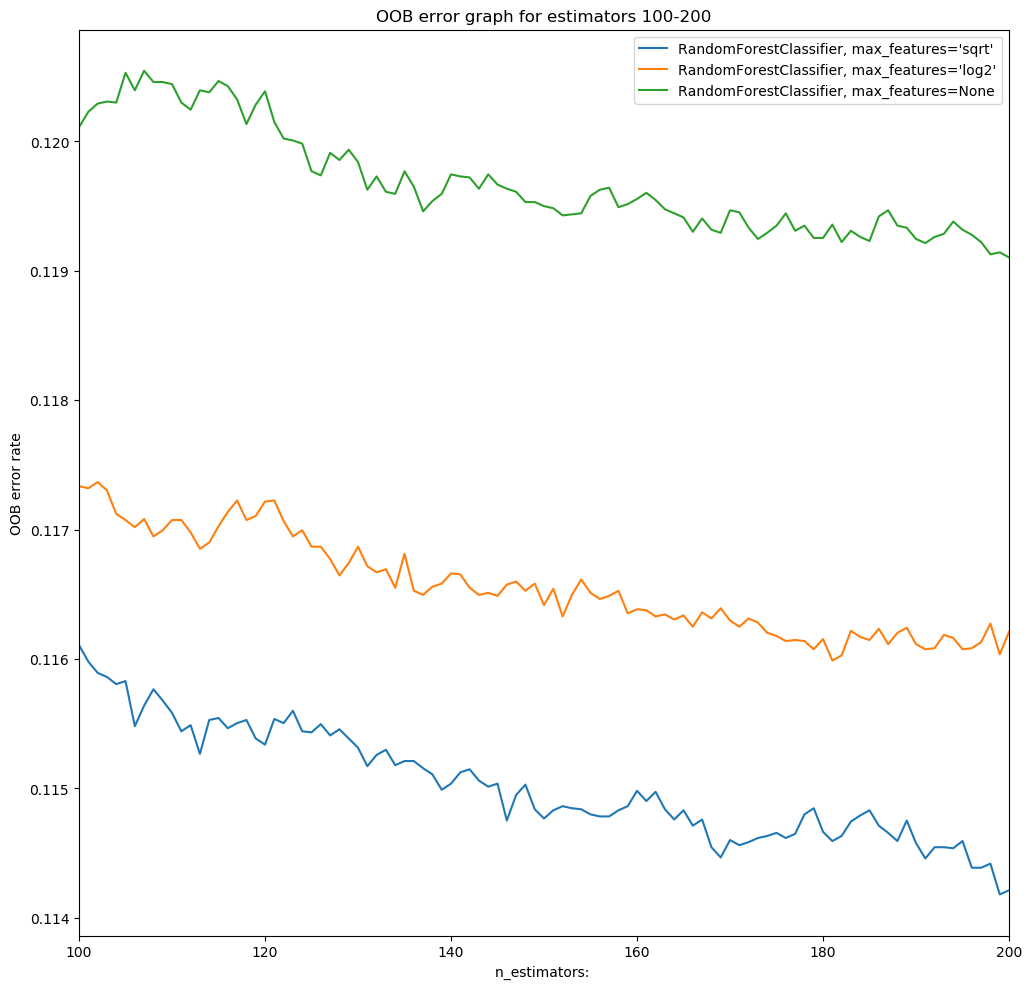

In [204]:
# create graph for all estimator and maxfeature
PlotOOBerrGraph(error_rate_1,min_estimators_1,max_estimators_1)

In [205]:
# create model for best estimator and feature based on lowest OOB error
rftchoosen_1,y_predict_training_rftchoosen_1,y_predict_test_rftchoosen_1=do_radomforest('sqrt',199,Xtrain, yTrain, Xtestlr, ytestlr)

In [206]:
# Range of `n_estimators` values to explore.
min_estimators_2 = 150
max_estimators_2 = 500
ensemble_clfs_2 = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate_2 = OrderedDict((label, []) for label, _ in ensemble_clfs_2)



for label, rfc in ensemble_clfs_2:
    for i in range(min_estimators_2, max_estimators_2 + 1):
        rfc.set_params(n_estimators=i)
        rfc.fit(Xtrain, yTrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error_2 = 1 - rfc.oob_score_
        error_rate_2[label].append((i, oob_error_2))

Least OOB error value for estimators 150-500
0.11344437928903117,444,RandomForestClassifier, max_features='sqrt'
0.11521149975434652,457,RandomForestClassifier, max_features='log2'
0.11853178439545464,498,RandomForestClassifier, max_features=None


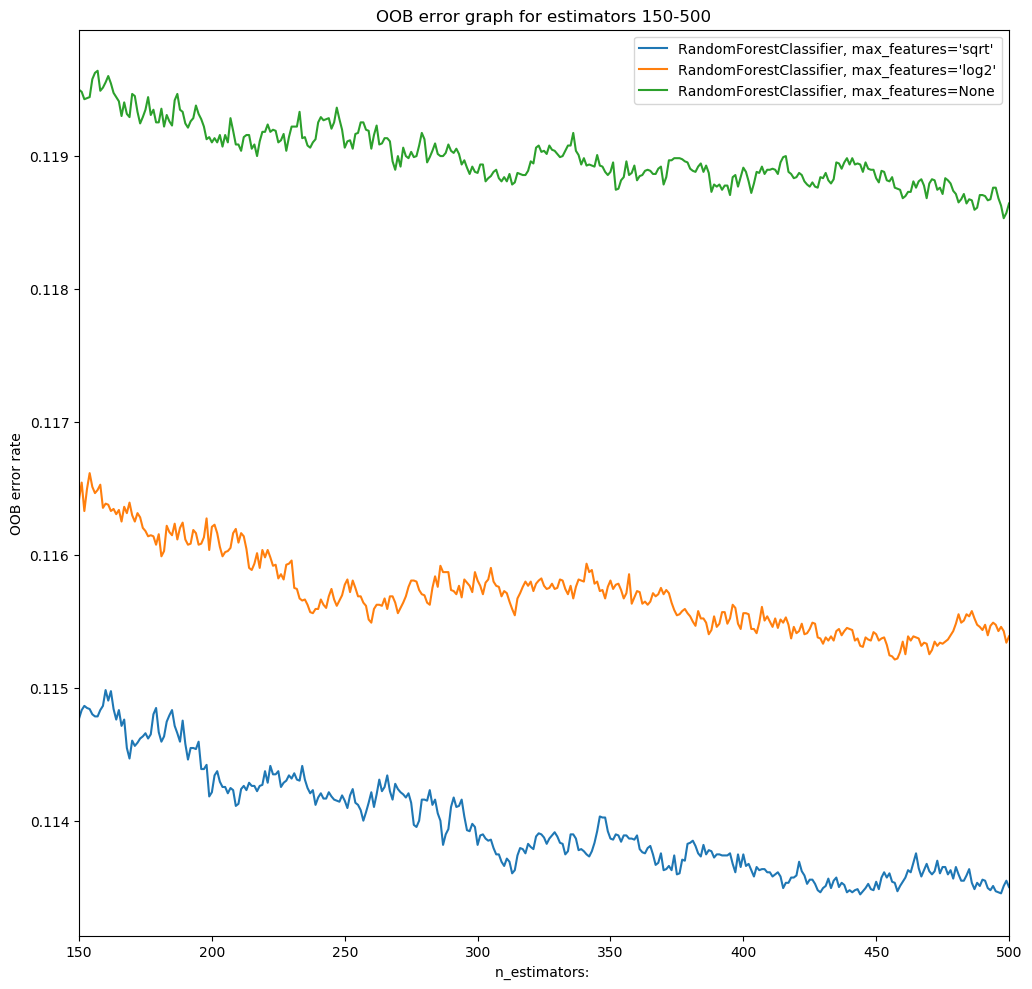

In [207]:
# create graph for all estimator and maxfeature
PlotOOBerrGraph(error_rate_2,min_estimators_2,max_estimators_2)

In [208]:
# create model for best estimator and feature based on lowest OOB error
rftchoosen_2,y_predict_training_rftchoosen_2,y_predict_test_rftchoosen_2=do_radomforest('sqrt',444,Xtrain, yTrain, Xtestlr, ytestlr)

In [209]:
# Range of `n_estimators` values to explore.
min_estimators_3 = 300
max_estimators_3 = 1000
ensemble_clfs_3 = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate_3 = OrderedDict((label, []) for label, _ in ensemble_clfs_3)



for label, rfc in ensemble_clfs_3:
    for i in range(min_estimators_3, max_estimators_3 + 1):
        rfc.set_params(n_estimators=i)
        rfc.fit(Xtrain, yTrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error_3 = 1 - rfc.oob_score_
        error_rate_3[label].append((i, oob_error_3))

Least OOB error value for estimators 300-1000
0.11327796884162478,997,RandomForestClassifier, max_features='sqrt'
0.11510055945607556,958,RandomForestClassifier, max_features='log2'
0.11833367671997086,823,RandomForestClassifier, max_features=None


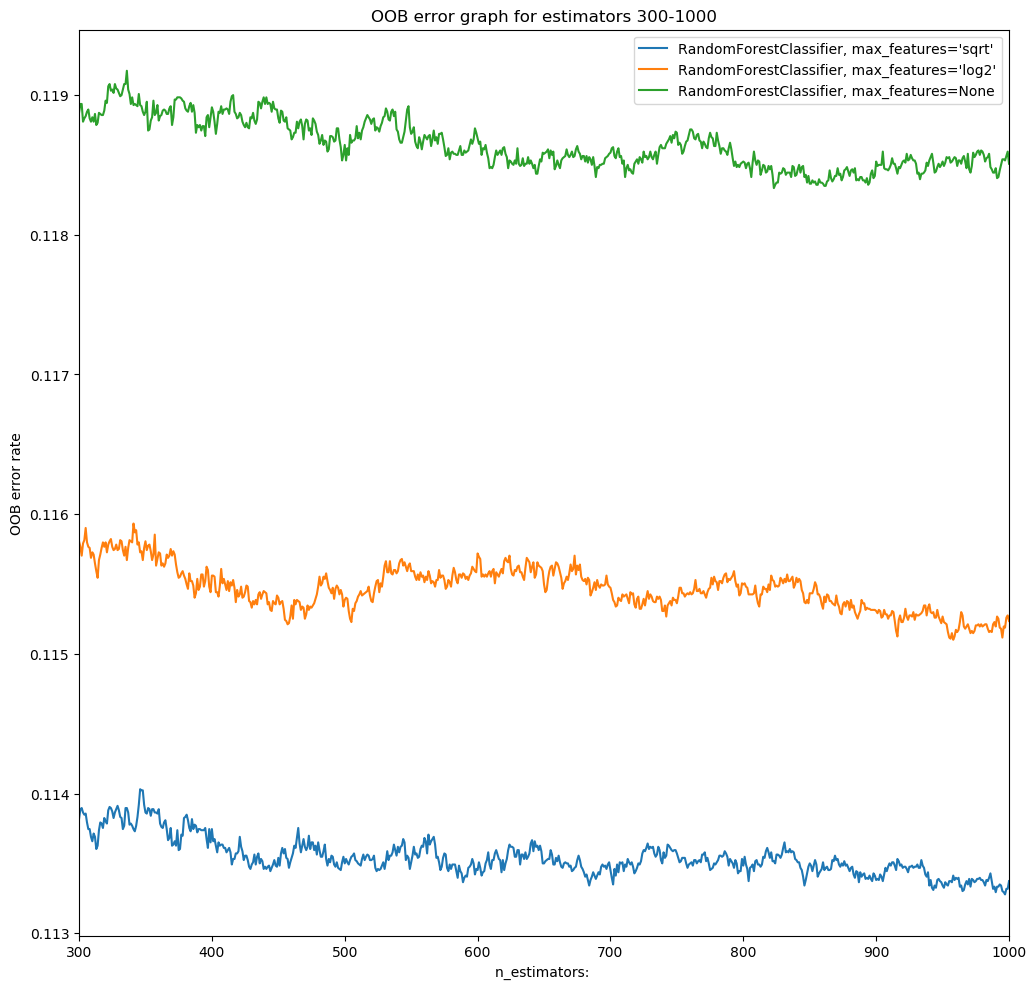

In [210]:
# create graph for all estimator and maxfeature
PlotOOBerrGraph(error_rate_3,min_estimators_3,max_estimators_3)

In [212]:
# create model for best estimator and feature based on lowest OOB error
rftchoosen_3,y_predict_training_rftchoosen_3,y_predict_test_rftchoosen_3=do_radomforest('sqrt',997,Xtrain, yTrain, Xtestlr, ytestlr)

#### backup variables(created after long processing) and models for further use r recreation

In [213]:
pickle.dump(error_rate, open( "pickle_RanForCl_error_rate_15-175.p", "wb" ) )
pickle.dump(error_rate_1, open( "pickle_RanForCl_error_rate_1_100-200.p", "wb" ) )
pickle.dump(error_rate_2, open( "pickle_RanForCl_error_rate_2_150-500.p", "wb" ) )
pickle.dump(error_rate_3, open( "pickle_RanForCl_error_rate_3_300-1000.p", "wb" ) )

In [214]:
class MultipleRunAccuracy :
    training_accuracy=0
    test_accuracy=0
    accuracy_difference=0
    def __init__(self):
        self.training_accuracy
        self.test_accuracy
        self.accuracy_difference

In [215]:
logregMultipleRunAccuracy=MultipleRunAccuracy()
logregMultipleRunAccuracy.accuracy_difference=accuracy_difference
logregMultipleRunAccuracy.training_accuracy=training_accuracy
logregMultipleRunAccuracy.test_accuracy=test_accuracy
pickle.dump(logregMultipleRunAccuracy, open( "pickle_logregMultipleRunAccuracy.p", "wb" ) )

In [216]:
class TestTrainSplitData :
    Xtrain=0
    yTrain=0
    Xtestlr=0
    ytestlr=0
    def __init__(self):
        self.Xtrain
        self.yTrain
        self.Xtestlr
        self.ytestlr

In [217]:
w=TestTrainSplitData()
w.Xtrain=Xtrain
w.yTrain=yTrain
w.Xtestlr=Xtestlr
w.ytestlr=ytestlr
pickle.dump(w, open( "pickle_TestTrainSplitData.p", "wb" ) )

In [218]:
class LogisticRegModels :
    modelwithL1=0
    modelwithL1_feature=0
    modelwithL2=0
    modelwithL2_feature=0
    def __init__(self):
        self.modelwithL1
        self.modelwithL1_feature
        self.modelwithL2
        self.modelwithL2_feature

In [219]:
c= LogisticRegModels()
c.modelwithL1=clf_l1
c.modelwithL1_feature=clf_f_l1
c.modelwithL2=clf_l2
c.modelwithL2_feature=clf_l2_f
joblib.dump(c, 'logregallmodels.pkl')

['logregallmodels.pkl']

In [220]:
# decided to extract model later from other vairble stored due to size of model (2gb each)
#joblib.dump(rftchoosen, 'rftchoosen.pkl')
#joblib.dump(rftchoosen_1, 'rftchoosen_1.pkl')
#joblib.dump(rftchoosen_2, 'rftchoosen_2.pkl')
#joblib.dump(rftchoosen_3, 'rftchoosen_3.pkl')

In [ ]:
#end